In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys
sys.path.append("..")

In [18]:
from platform import python_version
print(python_version())

3.6.8


In [19]:
import torch
from src.aggregator import *
from src.datagen.sinecurve import *
from src.datagen.gpcurve import *

## GP tester

- RBF
- Matern
- Additive
- Product

In [20]:
gpgen = RBFGPCurvesReader(16, 100)

In [21]:
a = gpgen.generate_curves()

In [22]:
import matplotlib.pyplot as plt

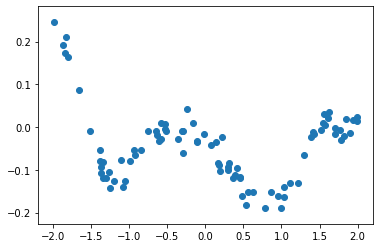

In [23]:
plt.scatter(a[0][0][0][0], a[0][0][1][0])

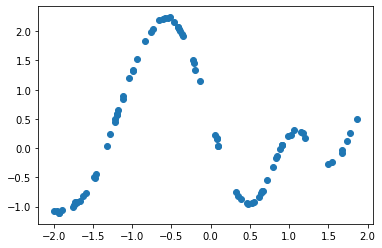

In [24]:
plt.scatter(a[0][0][0][1], a[0][0][1][1])

In [25]:
materngp = MaternGPCurvesReader(16,100)

In [26]:
a = gpgen.generate_curves()

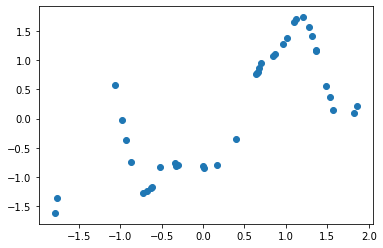

In [27]:
plt.scatter(a[0][0][0][0], a[0][0][1][0])

## Sine curve tester


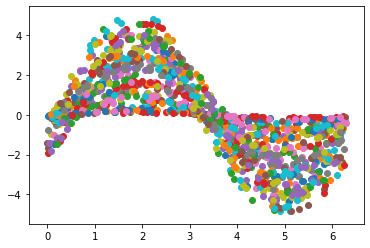

In [28]:
this = SineCurvesReader().generate_curves()
context_data_x, context_data_y = this.query[0]
context_data_x = context_data_x.squeeze()
context_data_y = context_data_y.squeeze()

context_data_x.shape
context_data_y.shape

for curve_id in range(context_data_x.shape[0]):
    plt.scatter(context_data_x[curve_id, :].tolist(), context_data_y[curve_id, :].tolist())

## Encoder

In [32]:
from src.decoder import *
from src.encoder import *
from src.utils import *

## Decoder

## Attentive Neural Process

In [33]:
from src.neural_process import *

## Training

In [34]:
TRAINING_ITERATIONS = 100000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 100 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
ATTENTION_TYPE = 'uniform' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

In [35]:
# Train dataset
dataset_train = RBFGPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = RBFGPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)
data_test = dataset_test.generate_curves()



In [36]:
#query = ((context_x, context_y), target_x)

In [37]:
data_train.query[0][0].shape

torch.Size([16, 23, 1])

In [38]:
data_train.query[0][1].shape

torch.Size([16, 23, 1])

In [39]:
data_train.query[1][0].shape

torch.Size([40, 1])

In [40]:
data_train.target_y.shape

torch.Size([16, 40, 1])

In [41]:
# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
x_dim = 1
y_dim = 1
r_dim = 64
z_dim = 64
hid_dim = 128
num_hid = 3

In [42]:
detencoder = DeterministicEncoder(x_dim, y_dim, r_dim, hid_dim=hid_dim, num_hid=num_hid)
latencoder = LatentEncoder(x_dim, y_dim, z_dim, hid_dim=hid_dim, num_hid=num_hid)
decoder = HeteroskedasticDecoder(x_dim, r_dim + z_dim, y_dim, hid_dim=hid_dim, num_hid=2)
att = Attention('mlp','multihead', x_dim, r_dim, hid_dim=hid_dim, num_hid=num_hid)
anp = AttentiveNeuralProcess(detencoder, att, latencoder, decoder, True)

In [43]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(anp.parameters(), lr=0.001)
EPOCHS = 500


In [44]:
from copy import deepcopy
base_parames = [p.data for p in anp.parameters()]
# base_parames

In [45]:
EPOCHS = 1000

In [61]:
y_context.select?

In [62]:
y_context.select(0, x_context_sorted_indices)

TypeError: select() received an invalid combination of arguments - got (int, Tensor), but expected one of:
 * (name dim, int index)
      didn't match because some of the arguments have invalid types: ([31;1mint[0m, [31;1mTensor[0m)
 * (int dim, int index)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [31;1mTensor[0m)


In [74]:
test, x_context_sorted_indices = x_context.sort(1)


In [76]:
x_context_sorted_indices

tensor([[[24],
         [41],
         [ 4],
         [30],
         [39],
         [ 2],
         [ 3],
         [34],
         [38],
         [20],
         [ 7],
         [13],
         [44],
         [32],
         [ 0],
         [31],
         [17],
         [18],
         [43],
         [ 6],
         [42],
         [23],
         [16],
         [ 9],
         [37],
         [40],
         [14],
         [11],
         [15],
         [28],
         [27],
         [29],
         [21],
         [10],
         [ 8],
         [ 5],
         [33],
         [12],
         [19],
         [26],
         [35],
         [36],
         [25],
         [22],
         [ 1]],

        [[ 9],
         [10],
         [33],
         [42],
         [ 4],
         [ 1],
         [24],
         [ 5],
         [ 7],
         [18],
         [39],
         [20],
         [13],
         [15],
         [21],
         [ 3],
         [34],
         [ 0],
         [12],
         [19],
         [40],
        

In [78]:
torch.gather(y_context, 1, x_context_sorted_indices)

tensor([[[ 1.1478e+00],
         [ 7.8395e-01],
         [ 4.5353e-02],
         [-5.7506e-02],
         [-8.3567e-02],
         [ 3.1350e-01],
         [ 2.8345e+00],
         [ 2.4027e+00],
         [ 2.3715e+00],
         [ 7.2392e-01],
         [ 9.7954e-02],
         [-1.2982e+00],
         [-6.3616e-01],
         [-4.2400e-01],
         [-3.6352e-01],
         [-7.6201e-02],
         [-7.7838e-01],
         [-8.1948e-01],
         [-7.2848e-01],
         [ 4.0134e-01],
         [ 4.8664e-01],
         [ 3.8944e-01],
         [ 3.3772e-01],
         [-3.9710e-01],
         [-5.8686e-01],
         [-9.0761e-01],
         [-1.0433e+00],
         [-1.1190e+00],
         [-1.1340e-01],
         [-6.4725e-01],
         [-6.2932e-01],
         [ 9.8804e-01],
         [-6.6413e-01],
         [-7.7660e-01],
         [-5.6543e-01],
         [-2.6240e-01],
         [-6.1594e-02],
         [-4.2486e-01],
         [ 4.8845e-01],
         [ 4.7571e-01],
         [ 8.3053e-01],
         [ 3.388

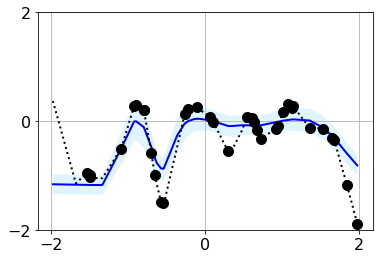

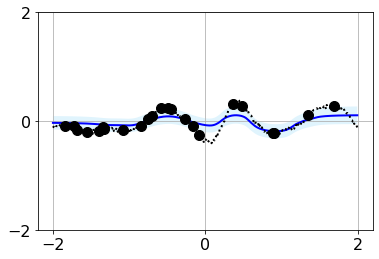

log_pred: 66.04810333251953, kl_target_context: 1.7460248272982426e-05, loss: -0.08424502611160278


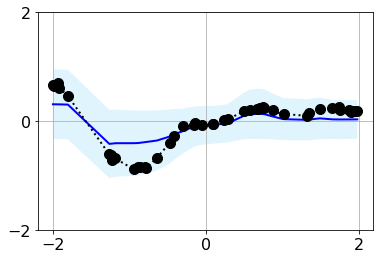

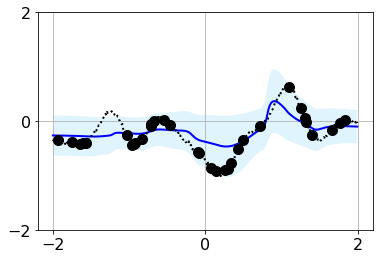

log_pred: -364.3567199707031, kl_target_context: 1.948589897438069e-06, loss: 0.46474072337150574


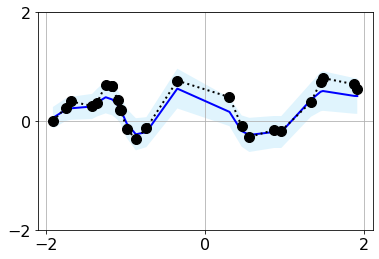

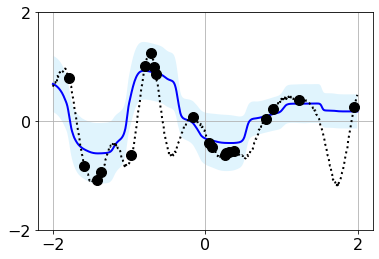

log_pred: 54.156333923339844, kl_target_context: 7.931025720608886e-07, loss: -0.13018348813056946


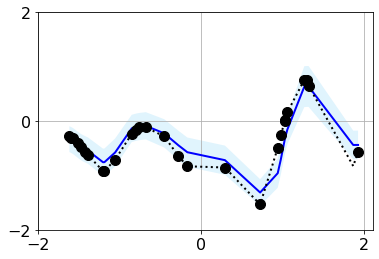

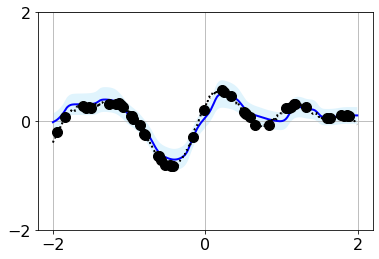

log_pred: 179.0299072265625, kl_target_context: 3.6010632697980327e-07, loss: -0.3858403265476227


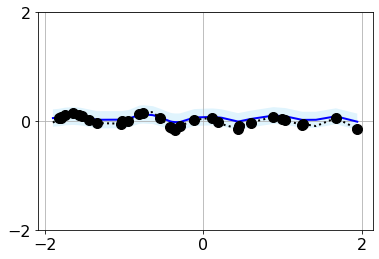

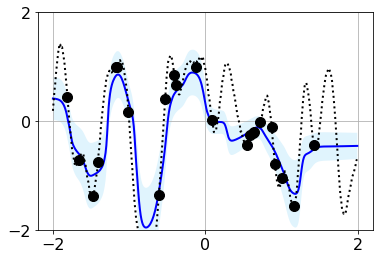

log_pred: 224.58193969726562, kl_target_context: 1.8622096149556455e-06, loss: -0.3509092926979065


KeyboardInterrupt: 

In [79]:
from src.utils import plot_functions

for epoch in range(EPOCHS):
    epoch_loss = 0
    # Train dataset
    dataset_train = RBFGPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)
    data_train = dataset_train.generate_curves()
    x_context = data_train.query[0][0].contiguous()
    x_context, x_context_sorted_indices = x_context.sort(1)
    y_context = data_train.query[0][1].contiguous()
    y_context = torch.gather(y_context, 1, x_context_sorted_indices)
    x_target = data_train.query[1].contiguous()
    x_target, x_target_sorted_indices = x_target.sort(1)
    y_target = data_train.target_y.contiguous()
    y_target = torch.gather(y_target, 1, x_target_sorted_indices)
    optimizer.zero_grad()
    
    y_target_mu, y_target_sigma, log_pred, kl_target_context, loss = anp.forward(x_context, y_context, x_target, y_target)
    loss.backward()
    optimizer.step()
    
    if (epoch % 100) == 0:
        plot_functions(x_target, y_target, x_context, y_context, y_target_mu, y_target_sigma)
        data_test = dataset_test.generate_curves()
        x_context = data_test.query[0][0].contiguous()
        y_context = data_test.query[0][1].contiguous()
        x_target = data_test.query[1].contiguous()
        y_target = data_test.target_y.contiguous()
        y_target_mu, y_target_sigma, _, _, _ = anp.forward(x_context, y_context, x_target, y_target)
#         plt.scatter(x_target[0].cpu(), y_target_mu[0].cpu().data)
#         plt.show()
#         plt.close()
#         plt.figure()
#         plt.scatter(x_context[0].cpu(), y_context[0].cpu())
#         plt.show()
#         plt.close()
        plot_functions(x_target, y_target, x_context, y_context, y_target_mu, y_target_sigma)
        print(f'log_pred: {log_pred.sum()}, kl_target_context: {kl_target_context.sum()}, loss: {loss.sum()}')

In [ ]:
batch_size, num_context_points, y_size = y_context.size()
_, num_target_points, _ = x_target.size()

# map the context points to their deterministic represnetations.
# r_i : Shape (batch_size, num_context_points, r_dim)
r_i = anp.deterministic_encoder(x_context, y_context)

In [ ]:
r_i.shape

In [ ]:
r_j = anp.attention(x_target, x_context, r_i)

In [ ]:
log_pred.shape

In [ ]:
kl_target_context.shape

In [ ]:
data_train.num_context_points

In [ ]:
x_context.shape

In [ ]:
data_train.num_total_points

In [ ]:
y_context.shape

In [ ]:
loss

In [ ]:
x_context[0].data

In [ ]:
plt.scatter(x_target[0], y_target_mu[0].data)
plt.scatter(x_context[0], y_context[0])

In [ ]:
plt.scatter(x_context[0], y_context[0])

In [ ]:
 y_context[0]